# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 

### Inicialmente codificar cada instante de tempo (sem usar janelas no tempo)
### Decodificar o momento que estava na mesma e na outra modalidade a partir do estado reduzido
* Comparar com decodificação usando: (1) Sinais originais, (2) PCA geral, (3) PCA em cada ponto, (4) Auto-encoder



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## O "report.all_trials_delay" tem o intervalo físico e report.time_target tem o intervalo estimado!

In [2]:
import sys
sys.path.append("../src/data")
from myMNE import makeMNE

In [3]:
from os import listdir
from os.path import isfile, join
mypath = '../data/raw/aud/'

onlyfiles = [mypath+"/"+f for f in listdir(mypath) if isfile(join(mypath, f))]
auds = list(map(makeMNE,onlyfiles))

In [4]:
data = np.array([aud.get_data().T for aud in auds])

## Consultar o André para descobrir onde está o outros 44 ms

In [13]:
550*4-539*4

44

In [5]:
print("{} pessoas, pontos, canais, trials".format(data.shape))


(20, 539, 64, 240) pessoas, pontos, canais, trials


In [19]:
def recortaTempo(data, tipo = 0): #exposicao 1
    #print(data.shape)
    # 750 ms - 1500 ms
    exposure = data[::,::,tipo::2]
    recorte = exposure[375-186:375]
    janelas  = np.split(recorte,6)
    # cada janela possui 31 pontos
    #print("Temos na janela um total de {:} pontos".format(recorte.shape[0]/6))
    # Para cada janela, pegamos a média presente nela
    media = lambda janela : np.average(janela,axis=0)
    com_media = np.array(list(map(media, janelas)))
    # Dessa forma, obtemos um vetor com formato
    #print("Vetor final com formato: {} ".format(com_media.shape))
    
    return com_media

In [20]:
exposicao1 = lambda x : recortaTempo(x, tipo=0)
exposicao2 = lambda x : recortaTempo(x, tipo=1)

In [21]:
exposure1 = (list(map(exposicao1,data)))
exposure2 = (list(map(exposicao1,data)))

In [23]:
np.array([exposure1,exposure2]).shape

(2, 20, 6, 64, 120)

## Com isso, iremos para o próximo passo, que consiste de aplicar o PCA para reduzir as dimensões redudantes presentes nos múltiplos canais.

Não realizamos nesse momento a separação do conjunto treino-teste, seguindo o autor original.


![aquisicao](https://raw.githubusercontent.com/bruAristimunha/Across-Modalities/master/reports/figures/mapa_rapha.jpg)
#### Figura 01: Diagrama de Reunião de Orientação. O ponto de interesse está na tabela para aplicação do PCA. Segundo os autores, eles empregaram em média 32 componentes +- 1

In [24]:
from sklearn.decomposition import PCA

In [65]:
def myPCA(data: np.array, return_data = False, n_components=0.99) -> PCA :
    
    #data = data.reshape(64,120)
    pca_ = PCA(random_state=42, svd_solver = 'full', n_components=n_components)
    
    data = data.T
    
    data_ft = pca_.fit_transform(data)
    #import pdb; pdb.set_trace()
    
    #import pdb; pdb.set_trace()
    if(return_data):
        return data_ft
    else:
        return pca_

In [47]:
myPCA_method = lambda df : myPCA(df, return_data=False)
myPCA_data = lambda df : myPCA(df, return_data=True)

In [48]:
divide = lambda x : np.split(x,6)

In [49]:
por_janela_expo1 = list(map(divide, exposure1))
por_janela_expo2 = list(map(divide, exposure2))

In [50]:
por_pessoa_expo1 = [ list(map(myPCA_method,np.array(pessoa).reshape(6,64,120))) for pessoa in por_janela_expo1]
por_pessoa_expo2 = [ list(map(myPCA_method,np.array(pessoa).reshape(6,64,120))) for pessoa in por_janela_expo2]

In [51]:
import matplotlib.pylab as plt
import matplotlib

font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

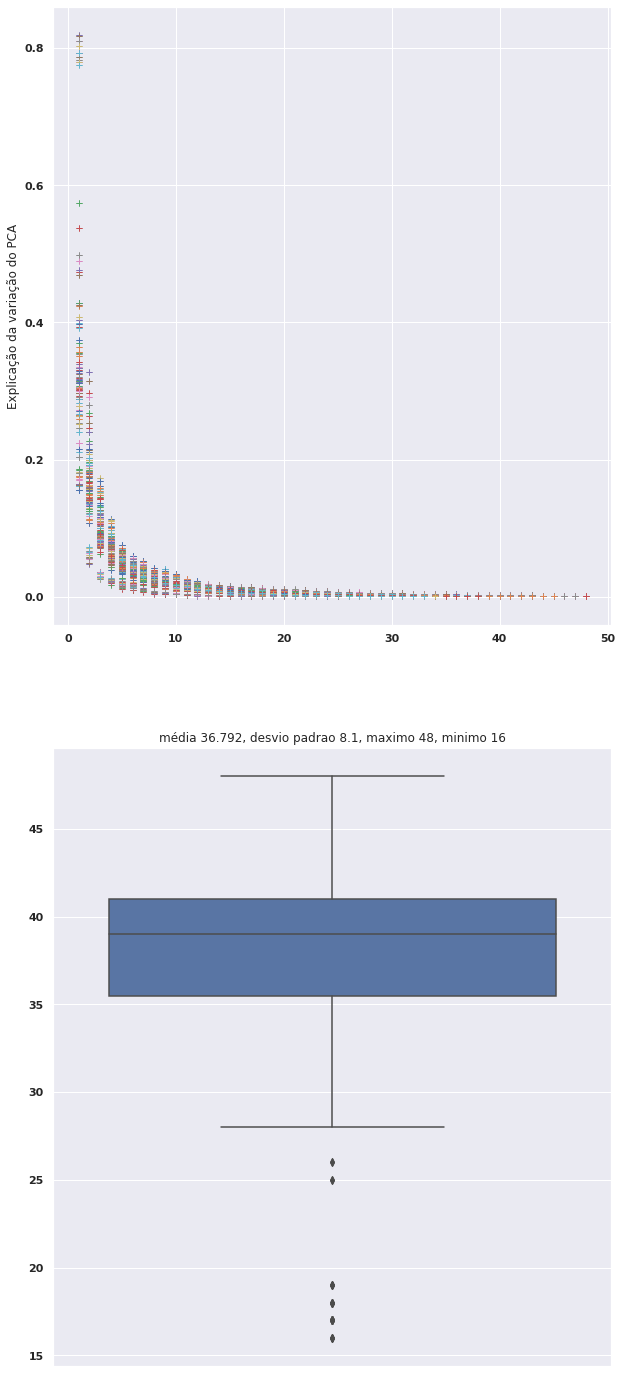

In [52]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 25))
method_pca = np.array(np.concatenate([por_pessoa_expo1,por_pessoa_expo2])).reshape(-1)
componentes = [pc.n_components_ for pc in method_pca]
for pc in method_pca:

    ax[0].plot(np.arange(1, pc.n_components_ + 1),
             pc.explained_variance_ratio_, '+', linewidth=2)
    ax[0].set_ylabel('Explicação da variação do PCA')

ax[1] = sns.boxplot(componentes,orient='vert',ax=ax[1])
ax[1].set_title("média {media:.5}, desvio padrao {std:.2}, maximo {maxi}, minimo {mini}".format(
                                                                        media = np.mean(componentes),
                                                                        std   = np.std(componentes), 
                                                                        maxi  = np.max(componentes),
                                                                        mini  = np.min(componentes)))
plt.show()

# Média consistente, desvio padrão não (talvez com visual). Minímo consistente e máximo também.
---


# Agora temos uma matriz de tamanhos variados, com 6 recortes de tempo para cada uma das 20 pessoas.

Definimos a média como tamanho adequado de número de componenetes para realizar a classificação.


In [66]:
myPCA_36_comp = lambda df : myPCA(df, return_data=True, n_components=37)

In [67]:
por_pessoa_expo1_data = [ list(map(myPCA_36_comp,np.array(pessoa).reshape(6,64,120))) for pessoa in por_janela_expo1]
por_pessoa_expo2_data = [ list(map(myPCA_36_comp,np.array(pessoa).reshape(6,64,120))) for pessoa in por_janela_expo2]

## Quase certeza que esse reshape está errado, mas vou verificar depois.

### Tentativa de arrumar está abaixo...
---

In [144]:
data_expo1 = np.array(por_pessoa_expo1_data)

In [150]:
corte = np.array(np.split(data_expo1,20))

In [162]:
corte_1 = list([np.array(np.split(corte_.reshape(6,120,37).T,37)) for corte_ in corte])

In [174]:
corte_1_ = np.array(corte_1).reshape(20, 37, 120, 6)

In [253]:
data_expo1.shape

(20, 6, 120, 37)

In [245]:
corte_1_ np.concatenate(corte_1_.T)

(720, 37, 20)

In [238]:
corte_1_.squeeze().shape

(20, 37, 120, 6)

In [209]:
corte_1_1 = np.concatenate()

In [210]:
corte_1_1.shape

(720, 37, 20)

In [191]:
a = np.array(np.split(corte_1_1,740))

In [195]:
np.concatenate(np.concatenate(a)).shape

(88800, 6)

In [106]:
pessoas_data =  np.split(np.array(por_pessoa_expo1_data).reshape(20*120,6,37),20*120)

In [87]:
vetor_y = [str(classe+1) for classe in range(6)]

In [137]:
pessoas_data_certo = [np.array(pessoas_data_error).reshape(6,37) for pessoas_data_error in pessoas_data]

In [138]:
dataframe = pd.DataFrame(np.concatenate(pessoas_data_certo))
dataframe = dataframe.reset_index()
dataframe['index'] = dataframe['index'] % 6

In [139]:
dataframe.columns = ['classe',       0,       1,       2,       3,       4,       5,       6,
             7,       8,       9,      10,      11,      12,      13,      14,
            15,      16,      17,      18,      19,      20,      21,      22,
            23,      24,      25,      26,      27,      28,      29,      30,
            31,      32,      33,      34,      35,      36]

In [141]:
y = dataframe['classe']
X = dataframe.drop('classe',1)

In [197]:
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [202]:
clf = GaussianNB()
clf = clf.fit(X_train, y_train)

In [203]:
y_pred = clf.predict(X_test)

In [207]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.07      0.10       485
           1       0.19      0.24      0.21       472
           2       0.17      0.45      0.25       481
           3       0.18      0.10      0.13       483
           4       0.23      0.09      0.13       467
           5       0.18      0.14      0.16       492

    accuracy                           0.18      2880
   macro avg       0.19      0.18      0.16      2880
weighted avg       0.19      0.18      0.16      2880



### EEG recordings and pre-processing

EEG was recorded continuously from 64 ActiCap Electrodes (Brain Products) at 1000 Hz by a QuickAmp amplifier (Brain Products). All sites were referenced to FCz and grounded to AFz. The electrodes were positioned according to the International 10–10 system. Additional bipolar electrodes registered the electrooculogram (EOG).



EEG pre-processing was carried out using BrainVision Analyzer (Brain Products). All data were down-sampled to 250 Hz and re-referenced to the average activity across electrodes. For eye movement artefact rejection, an independent component analysis (ICA) was performed on filtered (Butterworth Zero Phase Filter between 0.05.05 Hz and 30 Hz) and segmented (−200 to 2000 ms relative to S1) data. For the ICA, epochs were baselined based on the average activity of the entire trial. Eye related components were identified by comparing individual ICA components with EOG channels and by visual inspection. The average proportion of rejected trials for each participant corresponded to 0.0613. For all further analyses, epochs were baseline corrected based on the period between −200 ms and 0 ms relative to S1 presentation.

## 1 Sinais Originais

In [ ]:
Sinais_originais =  merge_data.reshape(10780*64,240)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA().fit(Sinais_originais)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');



## (2) PCA geral

In [ ]:
def makePlot(data):
    #fig = plt.figure()
    pca = PCA().fit(data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

    return fig 


In [ ]:
por_canal = [merge_data[:,:,i] for i in range(64)]

In [ ]:
figuras = list(map(makePlot, por_canal))

In [ ]:
figuras_0 = list(map(makePlot, por_canal))

fig, ax = plt.subplots(8,8, figsize=(20,20))




### Similarity between different trials and modalities

To calculate the similarity across trials we used a bootstrap approach. For each participant and comparison of interest, data from all intervals that lasted at least 1.125 s were divided into two groups of trials and averaged across trials per group (Bueno et al., 2017). Then, for each time point, data from each split (two-row vectors with the averaged amplitude values of all 62 electrodes) were compared using a Pearson correlation. This procedure was repeated 5000 times for each participant and Fisher transformed coefficients were averaged across permutations for each participant and comparison of interest.

At the group level, EEG-analyses were implemented non-parametrically (Maris and Oostenveld, 2007, Wolff et al., 2015) with sign-permutation tests. For each time-point, the Fisher transformed coefficients for a random half of the participants were multiplied by. The resulting distribution was used to calculate the p-value of the null-hypothesis that the mean value was equal to 0. Cluster-based permutation tests were then used to correct for multiple comparisons across time using 5000 permutations, with a cluster-forming threshold of p (Maris and Oostenveld, 2007). The sum of the values within a cluster was used as the cluster-level statistic. The significance threshold was set at p; all tests were one-sided.

### Decoding the elapsed interval

To investigate whether information about the elapsed interval could be decoded from activity across electrodes, we used a Naive Bayes classifier to perform a multiclass classification (Grootswagers et al., 2017). For all classifications, activity from the last 125 ms of the elapsed interval (−125 ms to 0 relative to S2) was averaged for each electrode. Data for each exposure (E1 and E2) were analysed separately. Intervals were divided into six equally sized bins (125 ms each).